## Exploratory data analysis 

This notebook is meant to explore the well test data

In [79]:
#import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from agents.utils.utils import make_plot_2y, make_plot
from scipy.optimize import curve_fit


In [80]:
#Load data - cheetah-20 as example
df = pd.read_csv('data/cheetah-20.csv')

#Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'], inplace=True)

        
#Select well test columns
df_subset = df[['Date', 'WT LIQ', 'WT THP', 'WT WCT', 'WT GL', 'WT Oil']].copy()
df_subset.dropna(inplace = True)


In [81]:
df_subset.index[0]

Timestamp('2023-07-08 00:00:00')

In [82]:
#Clean the dataset by removing outliers in oil rate
clean_rate = [df_subset['WT Oil'].iloc[0]]
index_list = [df_subset.index[0]]

for index, row in df_subset.iterrows():

    diff = np.log(row['WT Oil']/clean_rate[-1])
    if diff > -0.4:
        clean_rate.append(row['WT Oil'])
        index_list.append(index)


In [83]:
df_subset = df_subset.loc[index_list]

<Axes: xlabel='Date'>

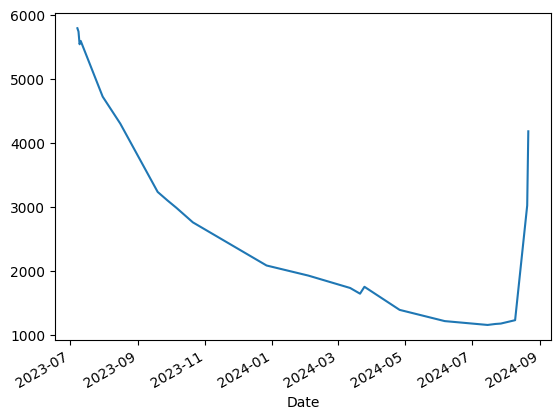

In [84]:
df_subset['WT Oil'].plot()

In [85]:
# Function to fit the decline curve
def fit_decline_curve(data, time_col, rate_col, auto = True, qi = None, Di = None, type = 'exponential'):
    # Extract time and rate data
    t = data[time_col]
    q = data[rate_col]

    # Define the exponential decline function
    def exponential_decline(t, qi, Di):
        return qi * np.exp(-Di * t)

    #Define the harmonic decline function
    def harmonic_decline(t, qi, Di):
        return qi / (1 + Di * t)
    
    if auto == True:
        if type == 'harmonic':
            # Fit the harmonic decline curve
            popt, _ = curve_fit(harmonic_decline, t, q, maxfev=10000)

            # Extract fitted parameters
            qi, Di = popt

            # Generate fitted values
            q_fit = harmonic_decline(t, qi, Di)

        elif type == 'exponential':
            # Fit the exponential decline curve
            popt, _ = curve_fit(exponential_decline, t, q, maxfev=10000)

            # Extract fitted parameters
            qi, Di = popt

            # Generate fitted values
            q_fit = exponential_decline(t, qi, Di)
        else:
            raise ValueError("Invalid type. Choose 'exponential' or 'harmonic'.")
    else: #Define the parameters manually
        qi = 6000
        Di = 0.008
        q_fit = exponential_decline(t, qi, Di)
    
    # Return fitted parameters and values
    return qi, Di, q_fit

# Fit the decline recursively
def recursive_fit(data, time_col, rate_col, auto = True, qi = None, Di = None, type_ = 'exponential'):
    # Initialize lists to store fitted parameters and values
    qi_list = []
    Di_list = []
    q_fit_list = []

    # Loop through the data in chunks
    for i in range(2, len(data)+1):
        chunk = data.tail(i)
        chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
        qi, Di, q_fit = fit_decline_curve(chunk, time_col, rate_col, auto, qi, Di, type=type_)
        
        # Append fitted parameters and values to the lists
        qi_list.append(qi)
        Di_list.append(Di)
        q_fit_list.append(q_fit)

    return qi_list, Di_list, q_fit_list

### Testing recursive DCA fitting

In [89]:
#try the recursive fit
df_subset_24 = df_subset[df_subset['Date'] < '2024-08-01']
qi_list, Di_list, q_fit_list = recursive_fit(df_subset_24, 'Days', 'WT Oil', auto = True, type_ = 'exponential')

/tmp/ipykernel_58615/63536407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/home/codespace/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_58615/63536407.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exponential_decline, t, q, maxfev=10000)
/tmp/ipykernel_58615/63536407.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [90]:
q_fit_list[8]

Date
2023-12-27    2.090371e+03
2024-02-03    6.561952e-14
2024-03-12    2.059884e-30
2024-03-21    2.542098e-34
2024-03-25    4.656016e-36
2024-04-26    5.896455e-50
2024-06-06    9.215465e-68
2024-07-15    1.064223e-84
2024-07-22    9.704454e-88
2024-07-27    6.538810e-90
Name: Days, dtype: float64

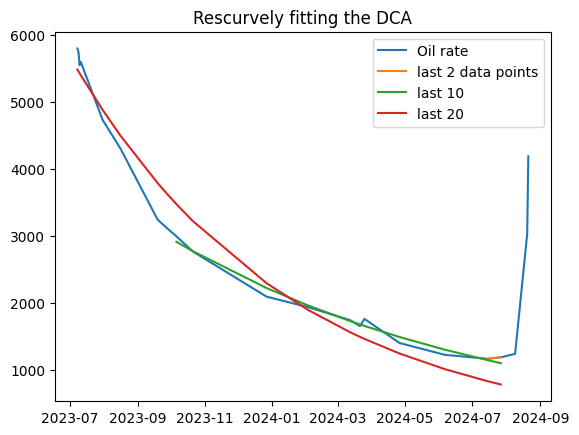

In [102]:
import matplotlib.pyplot as plt
#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
plt.plot(q_fit_list[1])
plt.plot(q_fit_list[10])
plt.plot(q_fit_list[19])

plt.title('Rescurvely fitting the DCA')
plt.legend(['Oil rate', 'last 2 data points', 'last 10', 'last 20', 'last 25', 'All'])

######################################
# Conclusion: This method does not work
######################################


### Testing Polynomial regression

In [94]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Fit the decline recursively
def poly_fit(data, time_col, rate_col):
    # Initialize lists to store fitted parameters and values
    prediction = []

    # Loop through the data in chunks
    for i in range(7, len(data)+1, 5):
        chunk = data.iloc[0:i]
        chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
        x = chunk[time_col].values.reshape(-1, 1)
        y = chunk[rate_col].values.reshape(-1, 1)
        
        #Define the model
        poly_model = PolynomialFeatures(degree=2)
        x_poly = poly_model.fit_transform(x)
        lr_model = LinearRegression()
        lr_model.fit(x_poly, y)

        y_pred = lr_model.predict(x_poly)
        
        chunk['poly_predicted'] = y_pred
        
        # Append fitted parameters and values to the lists
        prediction.append(chunk['poly_predicted'])

    return prediction

In [95]:
#try the recursive fit
prediction = poly_fit(df_subset_24, 'Days', 'WT Oil')

/tmp/ipykernel_58615/2269234527.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_58615/2269234527.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['poly_predicted'] = y_pred
/tmp/ipykernel_58615/2269234527.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

IndexError: list index out of range

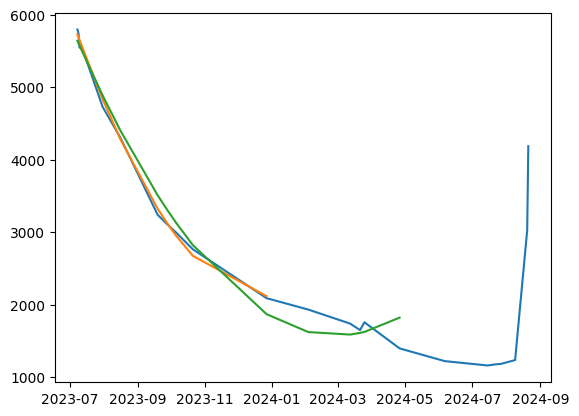

In [96]:
import matplotlib.pyplot as plt
#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
plt.plot(prediction[1])
plt.plot(prediction[2])
plt.plot(prediction[3])
plt.plot(prediction[5])
plt.title('')
plt.legend(['Oil rate', 'last 2 data points', 'last 10', 'last 20', 'last 25', 'All'])